# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


Developer : PraveenAI

.
The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 70000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (70000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(62864, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

89.80571428571429

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(62862, 10)


1    52600
0    10262
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[100]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[150]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[49]
print(sent_4900)
print("="*50)

Our dogs just love them.  I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe.
Although I have not bought canidae through Amazon (there is a local store near me that carries the life all stages 40LB bag for $35) I just wanted to write in and remark how impressed I am with this food.  I have an almost 2 year old chocalate lab.  When i got him from the breeder at 9 weeks he was on Eukanuba, which he stayed on with me at 1st.  After talking to a friend who breeds world class vizlas, she told me how she feeds them Canidae and how wonderful it is.  I switched over to Canidae then thank god and ever since.  My chocalate lab people actually think is a black lab.  He is the darkest chocolate lab u have ever seen, his coat is so beautiful and glossy, when he was on the eukanuba it was light brown and discolored.  Coats can be a huge problem with choc labs, but canidae has solved that problem.  With all the problems with men

In [15]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

Our dogs just love them.  I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe.


In [16]:
from bs4 import BeautifulSoup


In [17]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

Our dogs just love them.  I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe.
Although I have not bought canidae through Amazon (there is a local store near me that carries the life all stages 40LB bag for $35) I just wanted to write in and remark how impressed I am with this food.  I have an almost 2 year old chocalate lab.  When i got him from the breeder at 9 weeks he was on Eukanuba, which he stayed on with me at 1st.  After talking to a friend who breeds world class vizlas, she told me how she feeds them Canidae and how wonderful it is.  I switched over to Canidae then thank god and ever since.  My chocalate lab people actually think is a black lab.  He is the darkest chocolate lab u have ever seen, his coat is so beautiful and glossy, when he was on the eukanuba it was light brown and discolored.  Coats can be a huge problem with choc labs, but canidae has solved that problem.  With all the problems with men

In [18]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [19]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

I have been feeding my two labradors this food for about 3 yrs now and they are both doing well.<br />My older lab (13yrs.) seems to thrive on it and despite some level of arthritis in her hips, she still is very active. I do not mean to ascribe this to Canidae soley, but it certainly helps.


In [20]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

Our dogs just love them.  I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe.


In [21]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

I have been feeding my two labradors this food for about 3 yrs now and they are both doing well br My older lab 13yrs seems to thrive on it and despite some level of arthritis in her hips she still is very active I do not mean to ascribe this to Canidae soley but it certainly helps 


In [22]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [23]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████████████████████████████████████████████████████████████████████| 62862/62862 [00:32<00:00, 1918.33it/s]


In [24]:
preprocessed_reviews[1]

'dogs loves chicken product china wont buying anymore hard find chicken products made usa one isnt bad good product wont take chances till know going china imports'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [25]:
X = preprocessed_reviews
Y = final['Score']

In [26]:
from sklearn.cross_validation import train_test_split
X_1 , X_test , Y_1 , Y_test  = train_test_split(X,Y,test_size=0.3,random_state=0)
X_tr , X_cv , Y_tr , Y_cv  = train_test_split(X_1,Y_1,test_size=0.3,random_state=0)

C:\Users\RajMahendra\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [27]:
## Similartly you can do preprocessing for review summary also.

# [4] Featurization

## [4.1] BAG OF WORDS

In [153]:
#BoW
count_vect = CountVectorizer( min_df=20, max_df=100) #in scikit-learn
count_vect.fit(X_tr)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)


X_Bow_Tr = count_vect.transform(X_tr)
X_Bow_Cv = count_vect.transform(X_cv)
X_Bow_Test = count_vect.transform(X_test)

print("the type of count vectorizer ",type(X_Bow_Tr))
print("the shape of out text BOW vectorizer ",X_Bow_Tr.get_shape())
print("the number of unique words ", X_Bow_Tr.get_shape()[1])

some feature names  ['ability', 'absorb', 'absorbed', 'acai', 'accept', 'acceptable', 'accepted', 'access', 'accident', 'accidentally']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (30802, 3056)
the number of unique words  3056


In [154]:
Bow_Feature = count_vect.get_feature_names()

In [155]:
X_Bow_Tr   = X_Bow_Tr.toarray()

In [156]:
X_Bow_Cv   = X_Bow_Cv.toarray()

In [157]:
X_Bow_Test = X_Bow_Test.toarray()

In [158]:
X_Bow_Tr[1]

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

## [4.3] TF-IDF

In [160]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=20, max_df=100)
tf_idf_vect.fit(X_tr)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)


X_Tfidf_Tr = tf_idf_vect.transform(X_tr)
X_Tfidf_Cv = tf_idf_vect.transform(X_cv)
X_Tfidf_Test = tf_idf_vect.transform(X_test)

print("the type of count vectorizer ",type(X_Tfidf_Tr))
print("the shape of out text TFIDF vectorizer ",X_Tfidf_Tr.get_shape())
print("the number of unique words including both unigrams and bigrams ", X_Tfidf_Tr.get_shape()[1])

some sample features(unique words in the corpus) ['ability', 'able buy', 'able drink', 'able eat', 'able get', 'able make', 'able order', 'able purchase', 'able use', 'absolute best']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (30802, 7134)
the number of unique words including both unigrams and bigrams  7134


In [161]:
X_Tfidf_Tr = X_Tfidf_Tr.toarray()

In [162]:
X_Tfidf_Cv = X_Tfidf_Cv.toarray()

In [163]:
X_Tfidf_Test = X_Tfidf_Test.toarray()

In [164]:
tf_idf_feature = tf_idf_vect.get_feature_names()

from sklearn.preprocessing import StandardScaler
scalar = StandardScaler(with_mean=False)
scalar.fit(X_Tfidf_Tr)
X_Tfidf_Tr = scalar.transform(X_Tfidf_Tr)
X_Tfidf_Cv = scalar.transform(X_Tfidf_Cv)
X_Tfidf_Test = scalar.transform(X_Tfidf_Test)

In [39]:
X_Tfidf_Tr[100]

array([0., 0., 0., ..., 0., 0., 0.])

## [4.4] Word2Vec

In [40]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in X_tr:
    list_of_sentance.append(sentance.split())

In [41]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=20,size=100, workers=4)
    #print(w2v_model.wv.most_similar('great'))
    print('='*50)
    #print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        #print(w2v_model.wv.most_similar('great'))
        #print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

In [42]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", len(w2v_words))

number of words that occured minimum 5 times  4937
sample words  4937


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

In [43]:
# average Word2Vec
# compute average word2vec for each review.

def getAvgWordToVector(list_of_sentance):
    sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list    
    for sentence in list_of_sentance: # for each review/sentence
        sent = sentence.split()
        sent_vec = np.zeros(100) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
        cnt_words =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words:
                vec = w2v_model.wv[word]                
                sent_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
        sent_vectors.append(sent_vec)                   
    return sent_vectors

#### [4.4.1.1] Avg W2v

In [44]:
X_AvgW2V_Tr     = getAvgWordToVector(X_tr)

In [45]:
X_AvgW2V_Cv     = getAvgWordToVector(X_cv)

In [46]:
X_AvgW2V_Test   = getAvgWordToVector(X_test)

#### [4.4.1.2] TFIDF weighted W2v

In [47]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer(min_df=20, max_features=100) 
tf_idf_matrix = model.fit(X_tr)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [53]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

def getAvgW2VtfIdfToVector(list_of_sentance):
    tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
    row=0;
    for sentence in list_of_sentance: # for each review/sentence 
        sent = []        
        sent_vec = np.zeros(100) # as word vectors are of zero length
        weight_sum =0; # num of words with a valid vector in the sentence/review
        sent = sentence.split()
        for word in sent: # for each word in a review/sentence3     
            #print("word>>",word)
            if word in w2v_words and word in tfidf_feat:
                vec = w2v_model.wv[word]
                #tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
                # to reduce the computation we are 
                # dictionary[word] = idf value of word in whole courpus
                # sent.count(word) = tf valeus of word in this review
                tf_idf = dictionary[word]*(sent.count(word)/len(sent))
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
        if weight_sum != 0:
            sent_vec /= weight_sum
        tfidf_sent_vectors.append(sent_vec)
        row += 1
    return tfidf_sent_vectors

In [54]:
X_AvgW2VtfIdf_Tr     = getAvgW2VtfIdfToVector(X_tr)
X_AvgW2VtfIdf_Cv     = getAvgW2VtfIdfToVector(X_cv)
X_AvgW2VtfIdf_Test   = getAvgW2VtfIdfToVector(X_test)

# [5] Assignment 8: Decision Trees

<ol>
    <li><strong>Apply Decision Trees on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning (best `depth` in range [1, 5, 10, 50, 100, 500, 100], and the best `min_samples_split` in range [5, 10, 100, 500])</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Graphviz</strong>
        <ul>
    <li>Visualize your decision tree with Graphviz. It helps you to understand how a decision is being made, given a new vector.</li>
    <li>Since feature names are not obtained from word2vec related models, visualize only BOW & TFIDF decision trees using Graphviz</li>
    <li>Make sure to print the words in each node of the decision tree instead of printing its index.</li>
    <li>Just for visualization purpose, limit max_depth to 2 or 3 and either embed the generated images of graphviz in your notebook, or directly upload them as .png files.</li>                
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Find the top 20 important features from both feature sets <font color='red'>Set 1</font> and <font color='red'>Set 2</font> using `feature_importances_` method of <a href='https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html'>Decision Tree Classifier</a> and print their corresponding feature names</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying Decision Trees

## [5.1] Applying Decision Trees on BOW,<font color='red'> SET 1</font>

In [64]:
from sklearn.tree import DecisionTreeClassifier,export_graphviz
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc, roc_auc_score ,accuracy_score
from sklearn import tree

### Algorithm Paramtres and their Funcioning


<b>criterion            : </b> Which technique to be followed in creating the nodes.(GiniImpurity,Entropy)

<b>max_depth            : </b> It defines the Maximum No of Level Model go to construct a Tree

<b>min_samples_split    : </b> Minimum No of Samples to split a node.

<b>min_samples_leaf     : </b> Minimum No of Samples to consider it as a Pure node.

<b>max_features         : </b> No of Features to Consider while splitting/Creating for a New Node.

<b>max_leaf_nodes</b>  Maximum No of Pure Nodes that a can build with.

In [141]:
#https://github.com/cyanamous/Amazon-Food-Reviews-Analysis-and-Modelling/blob/master/5%20Amazon%20Food%20Reviews%20-%20SVM.ipynb
#https://github.com/cyanamous/Amazon-Food-Reviews-Analysis-and-Modelling/blob/master/6%20Amazon%20Food%20Reviews%20-%20Decision%20Trees.ipynb
#https://github.com/justmarkham/scikit-learn-videos/blob/master/08_grid_search.ipynb
Total_AUC= {}
params = {
    'max_depth' :[1, 5, 10, 50, 100, 500, 100],
    'min_samples_split' : [5, 10, 100, 500]
}

We are considered MaxDepth , Minimum Sapmles split as our Hypearameters.

We will Tune the for the Best AUC using Cross Validaion.

Will Train the Final Model with the Optimal Values returned by GridSearch.

Finall Will Evalute the Model, Checking its AUC and Accuracy

##### HyperParameters tunning by the CrossValidation for Best AUC

In [142]:
dt = DecisionTreeClassifier(criterion='gini', splitter='best', class_weight = "balanced")
gs = GridSearchCV(dt, param_grid=params, cv=5,scoring='roc_auc',n_jobs=-1)
gs.fit(X_Bow_Cv,Y_cv)
Set1_Cv_Results = pd.DataFrame(gs.cv_results_)[['mean_test_score', 'std_test_score', 'params']]
print(Set1_Cv_Results)

    mean_test_score  std_test_score  \
0          0.508274        0.002533   
1          0.508274        0.002533   
2          0.508274        0.002533   
3          0.508274        0.002533   
4          0.517711        0.003638   
5          0.517799        0.003334   
6          0.518161        0.003483   
7          0.518161        0.003483   
8          0.533494        0.008443   
9          0.534284        0.008666   
10         0.534170        0.007453   
11         0.534170        0.007453   
12         0.601007        0.011644   
13         0.601403        0.012075   
14         0.606906        0.011216   
15         0.607261        0.011589   
16         0.622704        0.011051   
17         0.627425        0.006912   
18         0.636511        0.008994   
19         0.633937        0.008543   
20         0.648225        0.007466   
21         0.667094        0.010498   
22         0.685108        0.010308   
23         0.683246        0.010441   
24         0.622078      

In [143]:
# examine the best model
print("\t best_score_     :",gs.best_score_)
print("\t best_params_    :",gs.best_params_)
#print(" best_estimator_ :",gs.best_estimator_)
Set1_best = gs.best_params_
Set1_best_max_depth         = gs.best_params_['max_depth']
Set1_best_min_samples_split = gs.best_params_['min_samples_split']
Set1_Cv_AUC = gs.best_score_

	 best_score_     : 0.6851076230897575
	 best_params_    : {'max_depth': 500, 'min_samples_split': 100}


We captured the Best Parametres that we want.

Let Train our Model with theese best Params and Draw AUC for bot Train and Test Data.

We also Evaluate the Model for its Train and Test Accuracy.

In [144]:
Set1_Weights = []
dt = DecisionTreeClassifier(criterion='gini',max_depth = Set1_best_max_depth,min_samples_split = Set1_best_min_samples_split , splitter='best', class_weight = "balanced")
dt.fit(X_Bow_Tr,Y_tr)
Set1_Weights = dt.feature_importances_.tolist()

 Train Data      AUC for the Best Lamda  is  0.8015679824558842
 Test Validaton  AUC for the BEst Lamda  is  0.711534011607579


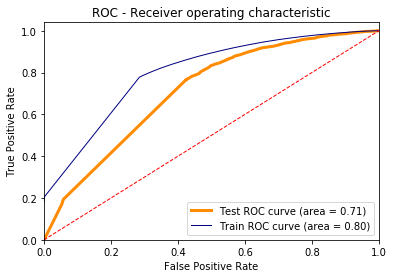

In [145]:
#https://qiita.com/bmj0114/items/460424c110a8ce22d945
Set1_Tr_prob    =  dt.predict_proba(X_Bow_Tr)    # Probablity of TRAIN-Validation
Set1_Tst_prob   =  dt.predict_proba(X_Bow_Test)    # Probablity of Cross-Validation

set1_tst_fpr, set1_tst_tpr, thresholds = roc_curve(Y_test,Set1_Tst_prob[:,1])
set1_tst_roc_auc = auc(set1_tst_fpr, set1_tst_tpr)

set1_train_fpr, set1_train_tpr, thresholds = roc_curve(Y_tr,Set1_Tr_prob[:,1])
set1_train_roc_auc = auc(set1_train_fpr, set1_train_tpr)


print(" Train Data      AUC for the Best Lamda  is ", set1_train_roc_auc)
print(" Test Validaton  AUC for the BEst Lamda  is ", set1_tst_roc_auc)

lw=1
plt.figure()
plt.plot(set1_tst_fpr, set1_tst_tpr, color='darkorange', lw=3, label='Test ROC curve (area = %0.2f)' % set1_tst_roc_auc)
plt.plot(set1_train_fpr, set1_train_tpr, color='navy', lw=1, label='Train ROC curve (area = %0.2f)' % set1_train_roc_auc)
plt.plot([0, 1], [0,1], color='red', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.04])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC - Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

#### Accuracy

In [146]:
Set1_Tr_Pred  =  dt.predict(X_Bow_Tr)
Set1_Tst_Pred =  dt.predict(X_Bow_Test)

Set1_Tr_Acc =  accuracy_score(Y_tr,Set1_Tr_Pred,normalize=True)
Set1_Tst_Acc =  accuracy_score(Y_test,Set1_Tst_Pred,normalize=True)

print("\n\tAccuracy for Train Data : ",Set1_Tr_Acc)
print("\tAccuracy for Test Data : ",Set1_Tst_Acc)


	Accuracy for Train Data :  0.7673852347250179
	Accuracy for Test Data :  0.7328066175300917


### Train Confusion Matrix


Train Accuracy :: 0.7673852347250179
Confusion Matrix::
 [[ 3556  1415]
 [ 5750 20081]] 



Text(83.4,0.5,'True label')

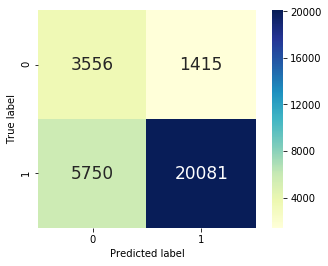

In [147]:
print("\nTrain Accuracy ::",Set1_Tr_Acc)
Train_CM= confusion_matrix(Y_tr, Set1_Tr_Pred, labels=None, sample_weight=None) 
print("Confusion Matrix::\n",Train_CM,"\n")
plt.imshow(Train_CM, cmap='binary')
sns.heatmap(Train_CM, cmap="YlGnBu", fmt="d"  ,annot=True,annot_kws={"size": 17})
plt.xlabel('Predicted label')
plt.ylabel('True label')  

### Test Confusion Matrix


Test Accuracy :: 0.7328066175300917


Confusion Matrix::
 [[ 1766  1291]
 [ 3748 12054]] 



Text(33,0.5,'True label')

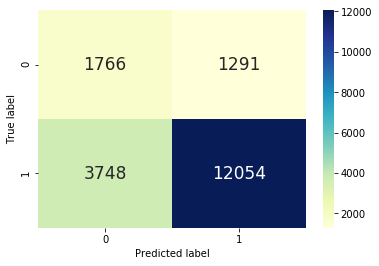

In [148]:
print("\nTest Accuracy ::",Set1_Tst_Acc)
Test_CM= confusion_matrix(Y_test, Set1_Tst_Pred, labels=None, sample_weight=None) 
print("\n\nConfusion Matrix::\n",Test_CM,"\n")
sns.heatmap(Test_CM, cmap="YlGnBu", fmt="d"  ,annot=True,annot_kws={"size": 17})
plt.xlabel('Predicted label')
plt.ylabel('True label') 

In [149]:
Total_AUC['set1']=[Set1_best , set1_tst_roc_auc , Set1_Tst_Acc]

### [5.1.1] Top 20 important features from<font color='red'> SET 1</font>

In [150]:
# Top Important features
set1_Imp_Features=pd.DataFrame([Bow_Feature,Set1_Weights],index=['feature','Decision_Imp']).T
#set1_Imp_Features= set1_Imp_Features[(set1_Imp_Features['Decision_Imp']>0)]
set1_Imp_Features_sortd = set1_Imp_Features.sort_values(by='Decision_Imp')[-20:][::-1]
set1_Imp_Features_sortd

,feature,Decision_Imp
3057,Lenght of Review,None
3056,No of Words,None
3044,yuck,0.0162269
2819,trash,0.0152514
2369,shame,0.0124486
1083,garbage,0.0116185
2206,returned,0.0112083
565,contacted,0.011208
918,expired,0.0103003
1274,hopes,0.0101598


### [5.1.2] Graphviz visualization of Decision Tree on BOW,<font color='red'> SET 1</font>

Graphiviz is and extrordinar Package, which helps to vizualize our Trees and Node Split Information.

For Better Vizualization We are building the Tree with MaxDepth 2 and Best Minimum Sapmles split, to Visualize the trees through Graphiviz.

In [151]:
Set1_Weights = []
dt = DecisionTreeClassifier(criterion='gini',max_depth = 2,min_samples_split = Set1_best_min_samples_split , splitter='best', class_weight = "balanced")
dt.fit(X_Bow_Tr,Y_tr)

DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=100,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [159]:
#http://webgraphviz.com/
export_graphviz(dt, out_file='./output/Set1.dot', 
                feature_names=Bow_Feature)

<img src=".\output\Set1.png">

## [5.2] Applying Decision Trees on TFIDF,<font color='red'> SET 2</font>

We are considered MaxDepth , Minimum Sapmles split as our Hypearameters.

We will Tune the for the Best AUC using Cross Validaion.

Will Train the Final Model with the Optimal Values returned by GridSearch.

Finall Will Evalute the Model, Checking its AUC and Accuracy

##### HyperParameters tunning by the CrossValidation for Best AUC

In [166]:
dt = DecisionTreeClassifier(criterion='gini', splitter='best', class_weight = "balanced")
gs = GridSearchCV(dt, param_grid=params, cv=5,scoring='roc_auc',n_jobs=-1)
gs.fit(X_Tfidf_Cv,Y_cv)
Set2_Cv_Results = pd.DataFrame(gs.cv_results_)[['mean_test_score', 'std_test_score', 'params']]
print(Set2_Cv_Results)

    mean_test_score  std_test_score  \
0          0.506888        0.001227   
1          0.506888        0.001227   
2          0.506888        0.001227   
3          0.506888        0.001227   
4          0.529788        0.002861   
5          0.529788        0.002861   
6          0.529800        0.002868   
7          0.529800        0.002868   
8          0.548143        0.005565   
9          0.547340        0.005477   
10         0.548333        0.005620   
11         0.548164        0.005569   
12         0.611975        0.009778   
13         0.607991        0.009284   
14         0.616581        0.008136   
15         0.616599        0.008140   
16         0.641308        0.006113   
17         0.649840        0.008440   
18         0.662701        0.007991   
19         0.662088        0.007992   
20         0.662748        0.012398   
21         0.689089        0.006255   
22         0.702723        0.011632   
23         0.705368        0.009606   
24         0.641380      

In [167]:
# examine the best model
print("\t best_score_     :",gs.best_score_)
print("\t best_params_    :",gs.best_params_)
#print(" best_estimator_ :",gs.best_estimator_)
Set2_best = gs.best_params_
Set2_best_max_depth         = gs.best_params_['max_depth']
Set2_best_min_samples_split = gs.best_params_['min_samples_split']
Set2_Cv_AUC = gs.best_score_

	 best_score_     : 0.7053676978214866
	 best_params_    : {'max_depth': 500, 'min_samples_split': 500}


We captured the Best Parametres that we want.

Let Train our Model with theese best Params and Draw AUC for bot Train and Test Data.

We also Evaluate the Model for its Train and Test Accuracy.

In [168]:
Set2_Weights = []
dt = DecisionTreeClassifier(criterion='gini',max_depth = Set2_best_max_depth,min_samples_split = Set2_best_min_samples_split,splitter='best', class_weight = "balanced")
dt.fit(X_Tfidf_Tr,Y_tr)
Set2_Weights = dt.feature_importances_.tolist()

 Train Data      AUC for the Best Lamda  is  0.8774725976183912
 Test Validaton  AUC for the BEst Lamda  is  0.739723602396139


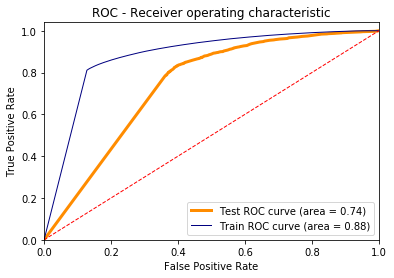

In [169]:
#https://qiita.com/bmj0114/items/460424c110a8ce22d945
Set2_Tr_prob    =  dt.predict_proba(X_Tfidf_Tr)    # Probablity of TRAIN-Validation
Set2_Tst_prob   =  dt.predict_proba(X_Tfidf_Test)    # Probablity of Cross-Validation

set2_tst_fpr, set2_tst_tpr, thresholds = roc_curve(Y_test,Set2_Tst_prob[:,1])
set2_tst_roc_auc = auc(set2_tst_fpr, set2_tst_tpr)

set2_train_fpr, set2_train_tpr, thresholds = roc_curve(Y_tr,Set2_Tr_prob[:,1])
set2_train_roc_auc = auc(set2_train_fpr, set2_train_tpr)

print(" Train Data      AUC for the Best Lamda  is ", set2_train_roc_auc)
print(" Test Validaton  AUC for the BEst Lamda  is ", set2_tst_roc_auc)

lw=1
plt.figure()
plt.plot(set2_tst_fpr, set2_tst_tpr, color='darkorange', lw=3, label='Test ROC curve (area = %0.2f)' % set2_tst_roc_auc)
plt.plot(set2_train_fpr, set2_train_tpr, color='navy', lw=1, label='Train ROC curve (area = %0.2f)' % set2_train_roc_auc)
plt.plot([0, 1], [0,1], color='red', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.04])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC - Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

#### Accuracy

In [170]:
Set2_Tr_Pred  =  dt.predict(X_Tfidf_Tr)
Set2_Tst_Pred =  dt.predict(X_Tfidf_Test)

Set2_Tr_Acc =  accuracy_score(Y_tr,Set2_Tr_Pred,normalize=True)
Set2_Tst_Acc =  accuracy_score(Y_test,Set2_Tst_Pred,normalize=True)

print("\n\tAccuracy for Train Data : ",Set2_Tr_Acc)
print("\tAccuracy for Test Data : ",Set2_Tst_Acc)


	Accuracy for Train Data :  0.8250438283228362
	Accuracy for Test Data :  0.7618113367622885


### Train Confusion Matrix


Train Accuracy :: 0.8250438283228362
Confusion Matrix::
 [[ 4307   664]
 [ 4725 21106]] 



Text(83.4,0.5,'True label')

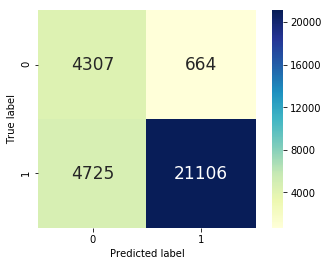

In [171]:
print("\nTrain Accuracy ::",Set2_Tr_Acc)
Train_CM= confusion_matrix(Y_tr, Set2_Tr_Pred, labels=None, sample_weight=None) 
print("Confusion Matrix::\n",Train_CM,"\n")
plt.imshow(Train_CM, cmap='binary')
sns.heatmap(Train_CM, cmap="YlGnBu", fmt="d"  ,annot=True,annot_kws={"size": 17})
plt.xlabel('Predicted label')
plt.ylabel('True label')

### Test Confusion Matrix


Test Accuracy :: 0.7618113367622885


Confusion Matrix::
 [[ 1947  1110]
 [ 3382 12420]] 



Text(33,0.5,'True label')

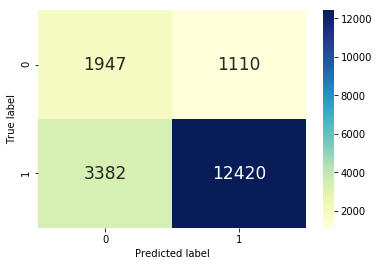

In [172]:
print("\nTest Accuracy ::",Set2_Tst_Acc)
Test_CM= confusion_matrix(Y_test, Set2_Tst_Pred, labels=None, sample_weight=None) 
print("\n\nConfusion Matrix::\n",Test_CM,"\n")
sns.heatmap(Test_CM, cmap="YlGnBu", fmt="d"  ,annot=True,annot_kws={"size": 17})
plt.xlabel('Predicted label')
plt.ylabel('True label') 

In [173]:
Total_AUC['set2']=[Set2_best , set2_tst_roc_auc , Set2_Tst_Acc]

### [5.2.1] Top 20 important features from<font color='red'> SET 2</font>

In [174]:
# Top Important features
set2_Imp_Features=pd.DataFrame([tf_idf_feature,Set2_Weights],index=['feature','Decision_Imp']).T
#set2_Imp_Features= set2_Imp_Features[(set2_Imp_Features['Decision_Imp']>0)]
set2_Imp_Features_sortd = set2_Imp_Features.sort_values(by='Decision_Imp')[-20:][::-1]
set2_Imp_Features_sortd

,feature,Decision_Imp
4028,never buy,0.0108999
4275,not purchase,0.010769
4162,not buying,0.0107302
7119,yuck,0.0102222
3642,made china,0.0101806
4324,not waste,0.00978263
6516,trash,0.00897477
363,bad batch,0.00870845
6631,two stars,0.0076635
5538,shame,0.00756586


### [5.2.2] Graphviz visualization of Decision Tree on TFIDF,<font color='red'> SET 2</font>

Graphiviz is Extrordinar technique, which helps to vizualize our Trees and Node Split Information.

For Better Vizualization We are building the Tree with MaxDepth 2 and Best Minimum Sapmles split, to Visualize the trees through Graphiviz.

In [175]:
dt = DecisionTreeClassifier(criterion='gini',max_depth = 2,min_samples_split = Set2_best_min_samples_split , splitter='best', class_weight = "balanced")
dt.fit(X_Tfidf_Tr,Y_tr)

DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=500,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [176]:
export_graphviz(dt, out_file='./output/Set2.dot', 
                feature_names=tf_idf_feature)

<img src=".\output\Set2.png">

## [5.3] Applying Decision Trees on AVG W2V,<font color='red'> SET 3</font>

##### HyperParameters tunning by the CrossValidation for Best AUC

In [178]:
dt = DecisionTreeClassifier(criterion='gini', splitter='best', class_weight = "balanced")
gs = GridSearchCV(dt, param_grid=params, cv=5,scoring='roc_auc',n_jobs=-1)
gs.fit(X_AvgW2V_Cv,Y_cv)
Set3_Cv_Results = pd.DataFrame(gs.cv_results_)[['mean_test_score', 'std_test_score', 'params']]
print(Set3_Cv_Results)

    mean_test_score  std_test_score  \
0          0.652240        0.012754   
1          0.652240        0.012754   
2          0.652240        0.012754   
3          0.652240        0.012754   
4          0.792895        0.012825   
5          0.793441        0.013072   
6          0.792237        0.013439   
7          0.791794        0.013899   
8          0.720129        0.011525   
9          0.723323        0.009228   
10         0.773056        0.001819   
11         0.798455        0.009690   
12         0.637680        0.005026   
13         0.657654        0.004605   
14         0.758535        0.003976   
15         0.798492        0.009707   
16         0.643417        0.005977   
17         0.657320        0.006827   
18         0.759202        0.004240   
19         0.798259        0.009895   
20         0.638952        0.001829   
21         0.656907        0.004555   
22         0.758206        0.004775   
23         0.798259        0.009895   
24         0.645343      

In [179]:
# examine the best model
print("\t best_score_     :",gs.best_score_)
print("\t best_params_    :",gs.best_params_)
#print(" best_estimator_ :",gs.best_estimator_)
Set3_best = gs.best_params_
Set3_best_max_depth         = gs.best_params_['max_depth']
Set3_best_min_samples_split = gs.best_params_['min_samples_split']
Set3_Cv_AUC = gs.best_score_

	 best_score_     : 0.798491629939966
	 best_params_    : {'max_depth': 50, 'min_samples_split': 500}


We captured the Best Parametres that we want.

Let Train our Model with theese best Params and Draw AUC for bot Train and Test Data.

We also Evaluate the Model for its Train and Test Accuracy.

In [180]:
Set3_Weights = []
dt = DecisionTreeClassifier(criterion='gini',max_depth = Set3_best_max_depth,min_samples_split = Set3_best_min_samples_split , splitter='best', class_weight = "balanced")
dt.fit(X_AvgW2V_Tr,Y_tr)
Set3_Weights = dt.feature_importances_.tolist()

 Train Data      AUC for the Best Lamda  is  0.8701639303944451
 Test Validaton  AUC for the BEst Lamda  is  0.813462213554828


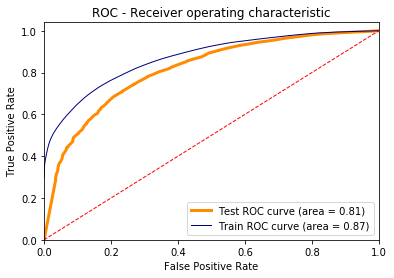

In [181]:
#https://qiita.com/bmj0114/items/460424c110a8ce22d945
Set3_Tr_prob    =  dt.predict_proba(X_AvgW2V_Tr)    # Probablity of TRAIN-Validation
Set3_Tst_prob   =  dt.predict_proba(X_AvgW2V_Test)    # Probablity of Cross-Validation

set3_tst_fpr, set3_tst_tpr, thresholds = roc_curve(Y_test,Set3_Tst_prob[:,1])
set3_tst_roc_auc = auc(set3_tst_fpr, set3_tst_tpr)

set3_train_fpr, set3_train_tpr, thresholds = roc_curve(Y_tr,Set3_Tr_prob[:,1])
set3_train_roc_auc = auc(set3_train_fpr, set3_train_tpr)


print(" Train Data      AUC for the Best Lamda  is ", set3_train_roc_auc)
print(" Test Validaton  AUC for the BEst Lamda  is ", set3_tst_roc_auc)

lw=1
plt.figure()
plt.plot(set3_tst_fpr, set3_tst_tpr, color='darkorange', lw=3, label='Test ROC curve (area = %0.2f)' % set3_tst_roc_auc)
plt.plot(set3_train_fpr,set3_train_tpr, color='navy', lw=1, label='Train ROC curve (area = %0.2f)' % set3_train_roc_auc)
plt.plot([0, 1], [0,1], color='red', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.04])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC - Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

##### Accuracy

In [182]:
Set3_Tr_Pred  =  dt.predict(X_AvgW2V_Tr)
Set3_Tst_Pred =  dt.predict(X_AvgW2V_Test)

Set3_Tr_Acc =  accuracy_score(Y_tr,Set3_Tr_Pred,normalize=True)
Set3_Tst_Acc =  accuracy_score(Y_test,Set3_Tst_Pred,normalize=True)

print("\n\tAccuracy for Train Data : ",Set3_Tr_Acc)
print("\tAccuracy for Test Data : ",Set3_Tst_Acc)


	Accuracy for Train Data :  0.7469969482501136
	Accuracy for Test Data :  0.7206108489315446


### Train Confusion Matrix


Train Accuracy :: 0.7469969482501136
Confusion Matrix::
 [[ 4158   813]
 [ 6980 18851]] 



Text(83.4,0.5,'True label')

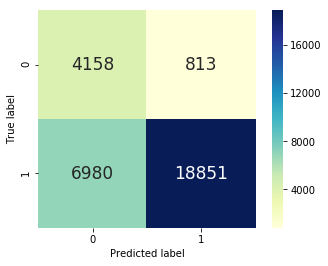

In [183]:
print("\nTrain Accuracy ::",Set3_Tr_Acc)
Train_CM= confusion_matrix(Y_tr, Set3_Tr_Pred, labels=None, sample_weight=None) 
print("Confusion Matrix::\n",Train_CM,"\n")
plt.imshow(Train_CM, cmap='binary')
sns.heatmap(Train_CM, cmap="YlGnBu", fmt="d"  ,annot=True,annot_kws={"size": 17})
plt.xlabel('Predicted label')
plt.ylabel('True label')  

### Test Confusion Matrix


Test Accuracy :: 0.7206108489315446


Confusion Matrix::
 [[ 2339   718]
 [ 4551 11251]] 



Text(33,0.5,'True label')

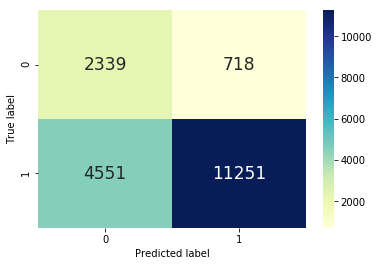

In [184]:
print("\nTest Accuracy ::",Set3_Tst_Acc)
Test_CM= confusion_matrix(Y_test, Set3_Tst_Pred, labels=None, sample_weight=None) 
print("\n\nConfusion Matrix::\n",Test_CM,"\n")
sns.heatmap(Test_CM, cmap="YlGnBu", fmt="d"  ,annot=True,annot_kws={"size": 17})
plt.xlabel('Predicted label')
plt.ylabel('True label') 

In [185]:
Total_AUC['set3']=[Set3_best , set3_tst_roc_auc , Set3_Tst_Acc]

## [5.4] Applying Decision Trees on TFIDF W2V,<font color='red'> SET 4</font>

#### HyperParameters tunning by the CrossValidation for Best AUC

In [187]:
dt = DecisionTreeClassifier(criterion='gini', splitter='best', class_weight = "balanced")
gs = GridSearchCV(dt, param_grid=params, cv=5,scoring='roc_auc',n_jobs=-1)
gs.fit(X_AvgW2VtfIdf_Cv,Y_cv)
Set4_Cv_Results = pd.DataFrame(gs.cv_results_)[['mean_test_score', 'std_test_score', 'params']]
print(Set4_Cv_Results)

    mean_test_score  std_test_score  \
0          0.616005        0.015808   
1          0.616005        0.015808   
2          0.616005        0.015808   
3          0.616005        0.015808   
4          0.725700        0.010668   
5          0.725700        0.010668   
6          0.726153        0.010716   
7          0.725571        0.013714   
8          0.631219        0.016196   
9          0.633058        0.015774   
10         0.699291        0.009152   
11         0.727024        0.008918   
12         0.586849        0.011336   
13         0.594797        0.011680   
14         0.688823        0.012761   
15         0.726904        0.008095   
16         0.591967        0.012746   
17         0.603698        0.010943   
18         0.688482        0.012064   
19         0.726904        0.008095   
20         0.587494        0.009540   
21         0.598741        0.011944   
22         0.687598        0.011021   
23         0.726904        0.008095   
24         0.592056      

In [188]:
# examine the best model
print("\t best_score_     :",gs.best_score_)
print("\t best_params_    :",gs.best_params_)
#print(" best_estimator_ :",gs.best_estimator_)
Set4_best = gs.best_params_
Set4_best_max_depth         = gs.best_params_['max_depth']
Set4_best_min_samples_split = gs.best_params_['min_samples_split']
Set4_Cv_AUC = gs.best_score_

	 best_score_     : 0.7270244512211854
	 best_params_    : {'max_depth': 10, 'min_samples_split': 500}


We captured the Best Parametres that we want.

Let Train our Model with theese best Params and Draw AUC for bot Train and Test Data.

We also Evaluate the Model for its Train and Test Accuracy.

In [189]:
Set4_Weights = []
dt = DecisionTreeClassifier(criterion='gini',max_depth = Set4_best_max_depth,min_samples_split = Set4_best_min_samples_split , splitter='best', class_weight = "balanced")
dt.fit(X_AvgW2VtfIdf_Tr,Y_tr)
Set4_Weights = dt.feature_importances_.tolist()

 Train Data      AUC for the Best Lamda  is  0.814931799746493
 Test Validaton  AUC for the BEst Lamda  is  0.7452701605826471


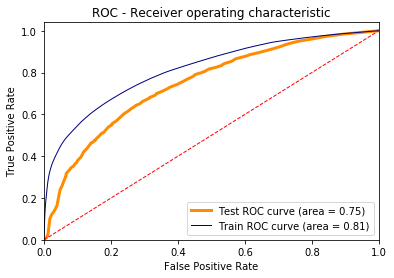

In [190]:
#https://qiita.com/bmj0114/items/460424c110a8ce22d945
Set4_Tr_prob    =  dt.predict_proba(X_AvgW2VtfIdf_Tr)    # Probablity of TRAIN-Validation
Set4_Tst_prob   =  dt.predict_proba(X_AvgW2VtfIdf_Test)    # Probablity of Cross-Validation

set4_tst_fpr, set4_tst_tpr, thresholds = roc_curve(Y_test,Set4_Tst_prob[:,1])
set4_tst_roc_auc = auc(set4_tst_fpr, set4_tst_tpr)

set4_train_fpr, set4_train_tpr, thresholds = roc_curve(Y_tr,Set4_Tr_prob[:,1])
set4_train_roc_auc = auc(set4_train_fpr, set4_train_tpr)


print(" Train Data      AUC for the Best Lamda  is ", set4_train_roc_auc)
print(" Test Validaton  AUC for the BEst Lamda  is ", set4_tst_roc_auc)

lw=1
plt.figure()
plt.plot(set4_tst_fpr, set4_tst_tpr, color='darkorange', lw=3, label='Test ROC curve (area = %0.2f)' % set4_tst_roc_auc)
plt.plot(set4_train_fpr,set4_train_tpr, color='navy', lw=1, label='Train ROC curve (area = %0.2f)' % set4_train_roc_auc)
plt.plot([0, 1], [0,1], color='red', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.04])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC - Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

#### Accuracy

In [191]:
Set4_Tr_Pred  =  dt.predict(X_AvgW2VtfIdf_Tr)
Set4_Tst_Pred =  dt.predict(X_AvgW2VtfIdf_Test)

Set4_Tr_Acc =  accuracy_score(Y_tr,Set4_Tr_Pred,normalize=True)
Set4_Tst_Acc =  accuracy_score(Y_test,Set4_Tst_Pred,normalize=True)

print("\n\tAccuracy for Train Data : ",Set4_Tr_Acc)
print("\tAccuracy for Test Data : ",Set4_Tst_Acc)


	Accuracy for Train Data :  0.6915784689305889
	Accuracy for Test Data :  0.6603743570708945


### Train Confusion Matrix


Train Accuracy :: 0.6915784689305889
Confusion Matrix::
 [[ 3982   989]
 [ 8511 17320]] 



Text(83.4,0.5,'True label')

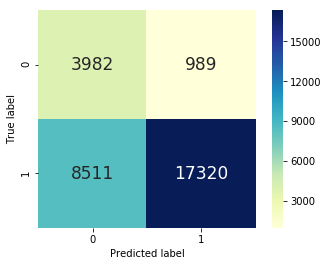

In [192]:
print("\nTrain Accuracy ::",Set4_Tr_Acc)
Train_CM= confusion_matrix(Y_tr, Set4_Tr_Pred, labels=None, sample_weight=None) 
print("Confusion Matrix::\n",Train_CM,"\n")
plt.imshow(Train_CM, cmap='binary')
sns.heatmap(Train_CM, cmap="YlGnBu", fmt="d"  ,annot=True,annot_kws={"size": 17})
plt.xlabel('Predicted label')
plt.ylabel('True label')  

### Test Confusion Matrix


Test Accuracy :: 0.6603743570708945


Confusion Matrix::
 [[ 2186   871]
 [ 5534 10268]] 



Text(33,0.5,'True label')

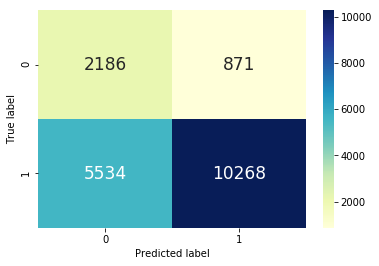

In [193]:
print("\nTest Accuracy ::",Set4_Tst_Acc)
Test_CM= confusion_matrix(Y_test, Set4_Tst_Pred, labels=None, sample_weight=None) 
print("\n\nConfusion Matrix::\n",Test_CM,"\n")
sns.heatmap(Test_CM, cmap="YlGnBu", fmt="d"  ,annot=True,annot_kws={"size": 17})
plt.xlabel('Predicted label')
plt.ylabel('True label') 

In [194]:
Total_AUC['set4']=[Set4_best , set4_tst_roc_auc , Set4_Tst_Acc]


## FueatureEngineering :Adding length of each review, No of words as New Feature

In the Way of imporving the Accuracy we can do some feature Engineerings.

Here we are Adding up the Two New Feature to the Datasets.

1. No of Words in Each Review

2. The lenght of each Review

In [195]:
def getNewFutre(old,org):
    len_Tr     = []
    Wrd_Cnt_Tr = []        
    for i in org:
        l = []
        w = []
        l.append(len(i))
        len_Tr.append(l) 
        w.append(len(i.split(' ')))
        Wrd_Cnt_Tr.append(w)        
    old= np.hstack((old,Wrd_Cnt_Tr))    
    old= np.hstack((old,len_Tr))
    return(old)           

In [196]:
X_Bow_Tr_new     = []
X_Bow_Cv_new     = []
X_Bow_Test_new   = []

X_Tfidf_Tr_new   = []
X_Tfidf_Test_new = []
X_Tfidf_Cv_new   = []

X_Bow_Test_new   = getNewFutre(X_Bow_Test,X_test)
X_Bow_Tr_new     = getNewFutre(X_Bow_Tr,X_tr)
X_Bow_Cv_new     = getNewFutre(X_Bow_Cv,X_cv)

X_Tfidf_Tr_new   = getNewFutre(X_Tfidf_Tr,X_tr)
X_Tfidf_Test_new = getNewFutre(X_Tfidf_Test,X_test)
X_Tfidf_Cv_new   = getNewFutre(X_Tfidf_Cv,X_cv)

In [197]:
Bow_Feature.extend(["No of Words"," Lenght of Review"])

In [198]:
tf_idf_feature.extend(["No of Words"," Lenght of Review"])

## [5.5] Applying Decision Trees on BagOfword New Dataset,<font color='red'> SET 5 </font>DataSet

Let us see, if our Feature Engineering hacks will results in Good Model Perfomance or not.

Firstly, will try with New Bag Of Words DataSet

#### HyperParameters tunning by the CrossValidation for Best AUC

In [199]:
dt = DecisionTreeClassifier(criterion='gini', splitter='best', class_weight = "balanced")
gs = GridSearchCV(dt, param_grid=params, cv=5,scoring='roc_auc',n_jobs=-1)
gs.fit(X_Bow_Cv_new,Y_cv)
Set5_Cv_Results = pd.DataFrame(gs.cv_results_)[['mean_test_score', 'std_test_score', 'params']]
print(Set5_Cv_Results)

    mean_test_score  std_test_score  \
0          0.524836        0.018588   
1          0.524836        0.018588   
2          0.524836        0.018588   
3          0.524836        0.018588   
4          0.549076        0.017754   
5          0.548960        0.016985   
6          0.549402        0.017602   
7          0.549402        0.017602   
8          0.560245        0.016183   
9          0.561566        0.013847   
10         0.562312        0.015054   
11         0.563493        0.016790   
12         0.590377        0.010784   
13         0.596039        0.016041   
14         0.606277        0.020665   
15         0.605149        0.018136   
16         0.586044        0.021140   
17         0.588973        0.019020   
18         0.615873        0.015656   
19         0.603883        0.019737   
20         0.607151        0.019719   
21         0.608462        0.018200   
22         0.624717        0.013607   
23         0.622232        0.018179   
24         0.586717      

In [200]:
# examine the best model
print("\t best_score_     :",gs.best_score_)
print("\t best_params_    :",gs.best_params_)
#print(" best_estimator_ :",gs.best_estimator_)
Set5_best = gs.best_params_
Set5_best_max_depth         = gs.best_params_['max_depth']
Set5_best_min_samples_split = gs.best_params_['min_samples_split']
Set5_Cv_AUC = gs.best_score_

	 best_score_     : 0.624717288137399
	 best_params_    : {'max_depth': 500, 'min_samples_split': 100}


We captured the Best Parametres that we want.

Let Train our Model with theese best Params and Draw AUC for bot Train and Test Data.

We also Evaluate the Model for its Train and Test Accuracy.

In [201]:
Set5_Weights = []
dt = DecisionTreeClassifier(criterion='gini',max_depth = Set5_best_max_depth,min_samples_split = Set5_best_min_samples_split , splitter='best', class_weight = "balanced")
dt.fit(X_Bow_Tr_new,Y_tr)
Set5_Weights = dt.feature_importances_.tolist()

 Train Data      AUC for the Best Lamda  is  0.9324923665307251
 Test Validaton  AUC for the BEst Lamda  is  0.6381837522626772


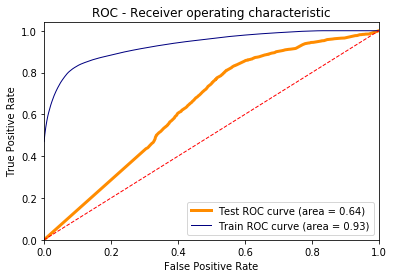

In [202]:
#https://qiita.com/bmj0114/items/460424c110a8ce22d945
Set5_Tr_prob    =  dt.predict_proba(X_Bow_Tr_new)    # Probablity of TRAIN-Validation
Set5_Tst_prob   =  dt.predict_proba(X_Bow_Test_new)    # Probablity of Cross-Validation

set5_tst_fpr, set5_tst_tpr, thresholds = roc_curve(Y_test,Set5_Tst_prob[:,1])
set5_tst_roc_auc = auc(set5_tst_fpr, set5_tst_tpr)

set5_train_fpr, set5_train_tpr, thresholds = roc_curve(Y_tr,Set5_Tr_prob[:,1])
set5_train_roc_auc = auc(set5_train_fpr, set5_train_tpr)


print(" Train Data      AUC for the Best Lamda  is ", set5_train_roc_auc)
print(" Test Validaton  AUC for the BEst Lamda  is ", set5_tst_roc_auc)

lw=1
plt.figure()
plt.plot(set5_tst_fpr, set5_tst_tpr, color='darkorange', lw=3, label='Test ROC curve (area = %0.2f)' % set5_tst_roc_auc)
plt.plot(set5_train_fpr, set5_train_tpr, color='navy', lw=1, label='Train ROC curve (area = %0.2f)' % set5_train_roc_auc)
plt.plot([0, 1], [0,1], color='red', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.04])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC - Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

#### Accuracy

In [203]:
Set5_Tr_Pred  =  dt.predict(X_Bow_Tr_new)
Set5_Tst_Pred =  dt.predict(X_Bow_Test_new)

Set5_Tr_Acc =  accuracy_score(Y_tr,Set5_Tr_Pred,normalize=True)
Set5_Tst_Acc =  accuracy_score(Y_test,Set5_Tst_Pred,normalize=True)

print("\n\tAccuracy for Train Data : ",Set5_Tr_Acc)
print("\tAccuracy for Test Data : ",Set5_Tst_Acc)


	Accuracy for Train Data :  0.8354327641062269
	Accuracy for Test Data :  0.737790975131237


#### Train Confusion Matrix


Train Accuracy :: 0.8354327641062269
Confusion Matrix::
 [[ 4534   437]
 [ 4632 21199]] 



Text(83.4,0.5,'True label')

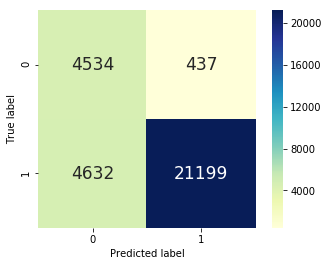

In [204]:
print("\nTrain Accuracy ::",Set5_Tr_Acc)
Train_CM= confusion_matrix(Y_tr, Set5_Tr_Pred, labels=None, sample_weight=None) 
print("Confusion Matrix::\n",Train_CM,"\n")
plt.imshow(Train_CM, cmap='binary')
sns.heatmap(Train_CM, cmap="YlGnBu", fmt="d"  ,annot=True,annot_kws={"size": 17})
plt.xlabel('Predicted label')
plt.ylabel('True label')  

#### Test Confusion Matrix


Test Accuracy :: 0.737790975131237


Confusion Matrix::
 [[ 1434  1623]
 [ 3322 12480]] 



Text(33,0.5,'True label')

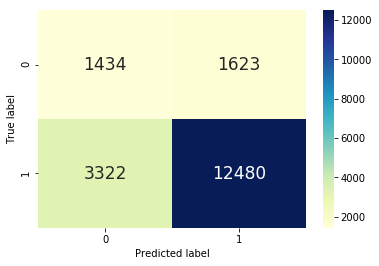

In [205]:
print("\nTest Accuracy ::",Set5_Tst_Acc)
Test_CM= confusion_matrix(Y_test, Set5_Tst_Pred, labels=None, sample_weight=None) 
print("\n\nConfusion Matrix::\n",Test_CM,"\n")
sns.heatmap(Test_CM, cmap="YlGnBu", fmt="d"  ,annot=True,annot_kws={"size": 17})
plt.xlabel('Predicted label')
plt.ylabel('True label') 

In [206]:
Total_AUC['set5']=[Set5_best , set5_tst_roc_auc , Set5_Tst_Acc]

### [5.5.1] Top 20 important features from<font color='red'> SET 5</font>

In [207]:
# Top Important features
set5_Imp_Features=pd.DataFrame([Bow_Feature,Set5_Weights],index=['feature','Decision_Imp']).T
#set1_Imp_Features= set1_Imp_Features[(set1_Imp_Features['Decision_Imp']>0)]
set5_Imp_Features_sortd = set5_Imp_Features.sort_values(by='Decision_Imp')[-20:][::-1]
set5_Imp_Features_sortd

,feature,Decision_Imp
3057,Lenght of Review,0.059049
3056,No of Words,0.0206319
3044,yuck,0.00745424
2819,trash,0.00699867
2369,shame,0.00544021
1083,garbage,0.00520455
2206,returned,0.00495298
918,expired,0.00480698
2088,rancid,0.00455149
2225,rip,0.00448932


## [5.6] Applying Decision Trees on New TFIDF Dataset,<font color='red'> SET 6</font>

Let us see, if our Feature Engineering hacks will results in Good Model Perfomance or not.

Firstly, will try with New Tf-Idf DataSet

##### HyperParameters tunning by the CrossValidation for Best AUC

In [209]:
dt = DecisionTreeClassifier(criterion='gini', splitter='best', class_weight = "balanced")
gs = GridSearchCV(dt, param_grid=params, cv=5,scoring='roc_auc',n_jobs=-1)
gs.fit(X_Tfidf_Cv_new,Y_cv)
Set6_Cv_Results = pd.DataFrame(gs.cv_results_)[['mean_test_score', 'std_test_score', 'params']]
print(Set6_Cv_Results)

    mean_test_score  std_test_score  \
0          0.515130        0.011475   
1          0.515130        0.011475   
2          0.515130        0.011475   
3          0.515130        0.011475   
4          0.557490        0.019423   
5          0.556748        0.020177   
6          0.556753        0.020178   
7          0.557166        0.019514   
8          0.568765        0.018222   
9          0.570244        0.016133   
10         0.569455        0.019420   
11         0.569544        0.019548   
12         0.615120        0.015630   
13         0.611965        0.015083   
14         0.622890        0.014348   
15         0.622711        0.014263   
16         0.610524        0.015898   
17         0.614158        0.013937   
18         0.628344        0.007583   
19         0.619041        0.013182   
20         0.632703        0.015887   
21         0.649777        0.018338   
22         0.643367        0.017610   
23         0.647374        0.022368   
24         0.614451      

In [210]:
# examine the best model
print("\t best_score_     :",gs.best_score_)
print("\t best_params_    :",gs.best_params_)
#print(" best_estimator_ :",gs.best_estimator_)
Set6_best = gs.best_params_
Set6_best_max_depth         = gs.best_params_['max_depth']
Set6_best_min_samples_split = gs.best_params_['min_samples_split']
Set6_Cv_AUC = gs.best_score_

	 best_score_     : 0.6497774812435755
	 best_params_    : {'max_depth': 500, 'min_samples_split': 10}


We captured the Best Parametres that we want.

Let Train our Model with theese best Params and Draw AUC for bot Train and Test Data.

We also Evaluate the Model for its Train and Test Accuracy.

In [211]:
Set6_Weights = []
dt = DecisionTreeClassifier(criterion='gini',max_depth = Set6_best_max_depth,min_samples_split = Set6_best_min_samples_split,splitter='best', class_weight = "balanced")
dt.fit(X_Tfidf_Tr_new,Y_tr)
Set6_Weights = dt.feature_importances_.tolist()

 Train Data      AUC for the Best Lamda  is  0.8774725976183912
 Test Validaton  AUC for the BEst Lamda  is  0.739723602396139


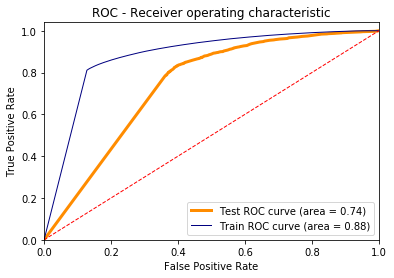

In [212]:
#https://qiita.com/bmj0114/items/460424c110a8ce22d945
Set6_Tr_prob    =  dt.predict_proba(X_Tfidf_Tr_new)    # Probablity of TRAIN-Validation
Set6_Tst_prob   =  dt.predict_proba(X_Tfidf_Test_new)    # Probablity of Cross-Validation

set6_tst_fpr, set6_tst_tpr, thresholds = roc_curve(Y_test,Set6_Tst_prob[:,1])
set6_tst_roc_auc = auc(set6_tst_fpr, set6_tst_tpr)

set6_train_fpr, set6_train_tpr, thresholds = roc_curve(Y_tr,Set6_Tr_prob[:,1])
set6_train_roc_auc = auc(set6_train_fpr, set6_train_tpr)

print(" Train Data      AUC for the Best Lamda  is ", set2_train_roc_auc)
print(" Test Validaton  AUC for the BEst Lamda  is ", set2_tst_roc_auc)

lw=1
plt.figure()
plt.plot(set2_tst_fpr, set2_tst_tpr, color='darkorange', lw=3, label='Test ROC curve (area = %0.2f)' % set2_tst_roc_auc)
plt.plot(set2_train_fpr, set2_train_tpr, color='navy', lw=1, label='Train ROC curve (area = %0.2f)' % set2_train_roc_auc)
plt.plot([0, 1], [0,1], color='red', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.04])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC - Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

##### Accuracy

In [213]:
Set6_Tr_Pred  =  dt.predict(X_Tfidf_Tr_new)
Set6_Tst_Pred =  dt.predict(X_Tfidf_Test_new)

Set6_Tr_Acc =  accuracy_score(Y_tr,Set6_Tr_Pred,normalize=True)
Set6_Tst_Acc =  accuracy_score(Y_test,Set6_Tst_Pred,normalize=True)

print("\n\tAccuracy for Train Data : ",Set6_Tr_Acc)
print("\tAccuracy for Test Data : ",Set6_Tst_Acc)


	Accuracy for Train Data :  0.9435101616778131
	Accuracy for Test Data :  0.7709316506707673


### Train Confusion Matrix


Train Accuracy :: 0.9435101616778131
Confusion Matrix::
 [[ 4912    59]
 [ 1681 24150]] 



Text(83.4,0.5,'True label')

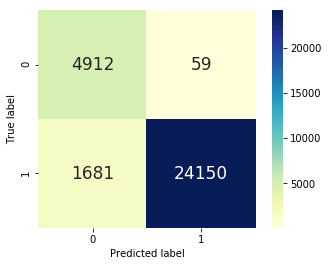

In [214]:
print("\nTrain Accuracy ::",Set6_Tr_Acc)
Train_CM= confusion_matrix(Y_tr, Set6_Tr_Pred, labels=None, sample_weight=None) 
print("Confusion Matrix::\n",Train_CM,"\n")
plt.imshow(Train_CM, cmap='binary')
sns.heatmap(Train_CM, cmap="YlGnBu", fmt="d"  ,annot=True,annot_kws={"size": 17})
plt.xlabel('Predicted label')
plt.ylabel('True label')  

### Test Confusion Matrix


Test Accuracy :: 0.7709316506707673


Confusion Matrix::
 [[ 1467  1590]
 [ 2730 13072]] 



Text(33,0.5,'True label')

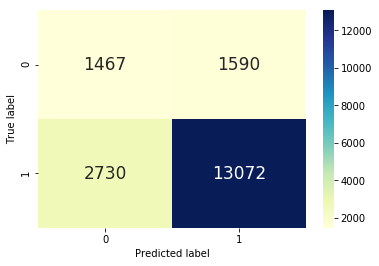

In [215]:
print("\nTest Accuracy ::",Set6_Tst_Acc)
Test_CM= confusion_matrix(Y_test, Set6_Tst_Pred, labels=None, sample_weight=None) 
print("\n\nConfusion Matrix::\n",Test_CM,"\n")
sns.heatmap(Test_CM, cmap="YlGnBu", fmt="d"  ,annot=True,annot_kws={"size": 17})
plt.xlabel('Predicted label')
plt.ylabel('True label') 

In [216]:
Total_AUC['set6']=[Set6_best , set6_tst_roc_auc , Set6_Tst_Acc]

### [5.6.1] Top 20 important features from<font color='red'> SET 6</font>

In [217]:
# Top Important features
set6_Imp_Features=pd.DataFrame([tf_idf_feature,Set6_Weights],index=['feature','Decision_Imp']).T
#set2_Imp_Features= set2_Imp_Features[(set2_Imp_Features['Decision_Imp']>0)]
set6_Imp_Features_sortd = set6_Imp_Features.sort_values(by='Decision_Imp')[-20:][::-1]
set6_Imp_Features_sortd

,feature,Decision_Imp
7135,Lenght of Review,0.0351647
7134,No of Words,0.01386
4275,not purchase,0.00638645
4028,never buy,0.00609103
4162,not buying,0.00578152
4324,not waste,0.00557623
3642,made china,0.00544926
7119,yuck,0.0051785
6516,trash,0.00480001
4218,not happy,0.00436671


# [6] Conclusions of Decision Trees

In [218]:
#Letus check all the neibours
from prettytable import PrettyTable

In [219]:
#http://zetcode.com/python/prettytable/
x = PrettyTable()
x.clear_rows()
Best_Acuracy = 0
Best_Model = ''
sets = ["BOW","TFIDF","W2V","TFIDFW2V","FE_BOW","FE_TFIDF"]
x.field_names = ["SET#", "SET", "Best Hyper parameter", "Test AUC", "Test Accuracy"]
for i,j in enumerate(Total_AUC) :    
    #print(j,sets[(i%4)],"Brute",Total_ACU[j][0],Total_ACU[j][1])
    x.add_row([ j,sets[i],Total_AUC[j][0],Total_AUC[j][1],Total_AUC[j][2]])
    if(Total_AUC[j][2]>Best_Acuracy):
        Best_Acuracy = Total_AUC[j][2]
        Best_Model = sets[i]      
print(x)

+------+----------+----------------------------------------------+--------------------+--------------------+
| SET# |   SET    |             Best Hyper parameter             |      Test AUC      |   Test Accuracy    |
+------+----------+----------------------------------------------+--------------------+--------------------+
| set1 |   BOW    | {'max_depth': 500, 'min_samples_split': 100} | 0.711534011607579  | 0.7328066175300917 |
| set2 |  TFIDF   | {'max_depth': 500, 'min_samples_split': 500} | 0.739723602396139  | 0.7618113367622885 |
| set3 |   W2V    | {'max_depth': 50, 'min_samples_split': 500}  | 0.813462213554828  | 0.7206108489315446 |
| set4 | TFIDFW2V | {'max_depth': 10, 'min_samples_split': 500}  | 0.7452701605826471 | 0.6603743570708945 |
| set5 |  FE_BOW  | {'max_depth': 500, 'min_samples_split': 100} | 0.6381837522626772 | 0.737790975131237  |
| set6 | FE_TFIDF | {'max_depth': 500, 'min_samples_split': 10}  | 0.6646134738123566 | 0.7709316506707673 |
+------+----------+

We can notice that More the Min Smaples split is giving the Descent Accuracy and AUC combination.

Both TF-IDF and W2V is giving us the better combination of AUC and Accuracies.